In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
from spike_train_utils import get_lv
os.chdir(current_wd)

In [7]:
dataset_folder = project_folder_path + 'results\\mice\\dataset\\cut_30min\\'
fig_folder = project_folder_path + 'results\\mice\\fig_draft_paper\\'

In [31]:
calculate_lv = False
save_fig = True

In [4]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

#### Get data

In [8]:
if calculate_lv:
    csv_data_file = dataset_folder + 'sua_list_constrained.csv'
    with open(csv_data_file, newline='') as f:
        reader = csv.reader(f)
        sua_list = list(reader)
    print(f'Loaded N units {len(sua_list)}')

    units_info_df = pd.read_pickle(dataset_folder + 'sua_list_constrained_units_df.pkl')
    units_info_df.head(2)

    # calculate Lv
    lv_l, unit_id_l = [], []
    for signal_idx, signal in enumerate(sua_list):
        if signal_idx%500 == 0:
            print(f'###\nCalculating for {signal_idx} signal')
        spikes = [int(spike) for spike in signal[8:]]
        lv = get_lv(spikes, verbose_=False)
        lv_l.append(lv)
        unit_id_l.append(signal[2])
    
    lv_df = pd.DataFrame({'unit_id': unit_id_l, 'lv': lv_l})
    lv_df = lv_df.merge(units_info_df, on='unit_id', how='left')

    lv_df.to_pickle(dataset_folder + 'lv_df.pkl')
else:
    lv_df = pd.read_pickle(dataset_folder + 'lv_df.pkl')

#### Plot

In [9]:
brain_areas_axes_ticks = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

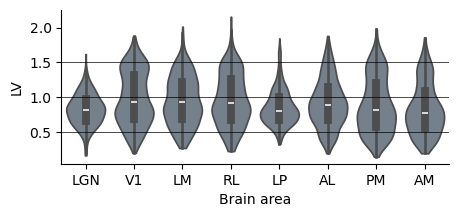

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(5,2))

sns.violinplot(ax=axes, x='ecephys_structure_acronym', y='lv', data=lv_df, 
               cut=0, density_norm='width', color='slategray', order=brain_areas_axes_ticks)
axes.axhline(y=1, lw=0.5, color='k')
axes.axhline(y=1.5, lw=0.5, color='k')
axes.axhline(y=0.5, lw=0.5, color='k')
axes.set_xlabel('Brain area')
axes.set_ylabel('LV')
axes.set_xticks(brain_areas_axes_ticks)
axes.set_xticklabels(brain_areas_names)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'lv_per_area.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'lv_per_area.svg' , bbox_inches='tight')

In [12]:
results_folder_syn = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'
lv_syn_df = pd.read_pickle(results_folder_syn + 'lv_df.pkl')
lv_syn_df.describe()

,unit_id,alpha,fr,tau_ms,lv
count,100000.000000,100000.000000,100000.000000,100000.000000,99966.000000
mean,49999.500000,0.499468,5.011243,175.143065,1.249773
std,28867.657797,0.231047,2.882324,72.114485,0.175255
min,0.000000,0.100018,0.010132,50.004382,0.000000
25%,24999.750000,0.298420,2.512284,112.542179,1.103157
50%,49999.500000,0.498300,5.029571,175.224718,1.230040
75%,74999.250000,0.699827,7.498982,237.745040,1.363477
max,99999.000000,0.899998,9.999937,299.996581,3.000000


In [28]:
p5 = np.percentile(lv_syn_df['lv'].dropna().values, 2.5)
p95 = np.percentile(lv_syn_df['lv'].dropna().values, 97.5)
print(p5, p95)

1.0129099580750591 1.6252361133911832


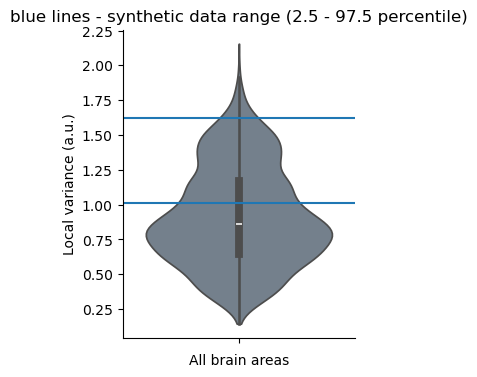

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(3,4))

sns.violinplot(ax=axes, y='lv', data=lv_df, 
               cut=0, density_norm='width', color='slategray')
axes.set_xlabel('All brain areas')
axes.set_ylabel('Local variance (a.u.)')
axes.axhline(y=p5)
axes.axhline(y=p95)
axes.set_title('blue lines - synthetic data range (2.5 - 97.5 percentile)')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'lv_all_area.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'lv_all_area.svg' , bbox_inches='tight')